In [175]:
import pandas as pd

Importamos los set de datos

In [4]:
train_set = pd.read_csv("j0001_train (1).csv")
test_set = pd.read_csv("j0001_X_test.csv")

Sólo se hará el análisis exploratorio sobre train ya que se asume que test son observaciones que no se tienen previamente a la construcción del algoritmo.

Accedemos a la información básica del Set de Datos.

In [13]:
dim=train_set.shape
print("numero de filas:"+ str(dim[0]))
print("numero de columnas:"+str(dim[1]))

numero de filas:2100
numero de columnas:5


In [14]:
print(train_set.dtypes)

feature1    float64
feature2    float64
feature3    float64
feature4    float64
target      float64
dtype: object


Todas las variables son numéricas

In [18]:
print("Estadísticos básicos del set de Datos")
print(" ")
print(train_set.describe())

Estadísticos básicos del set de Datos
 
          feature1     feature2     feature3     feature4       target
count  2100.000000  2100.000000  2100.000000  2100.000000  2100.000000
mean     -0.027414     0.001468    -0.013670    -0.016315    -1.325515
std       0.986569     0.993519     1.003757     1.008821    49.995929
min      -3.193735    -3.986392    -2.987483    -3.254383  -153.822702
25%      -0.705434    -0.637161    -0.704697    -0.714512   -36.070943
50%      -0.030567     0.030049    -0.022917    -0.021288    -1.646837
75%       0.670686     0.665407     0.673575     0.693128    32.707651
max       3.277599     3.190221     3.207883     3.281604   170.703958


Estudiamos na,s.

In [23]:
print(train_set.isna().any(axis=0))

feature1    False
feature2    False
feature3    False
feature4    False
target      False
dtype: bool


No hay na,s

In [135]:
import seaborn as sns
import matplotlib.pyplot as plt

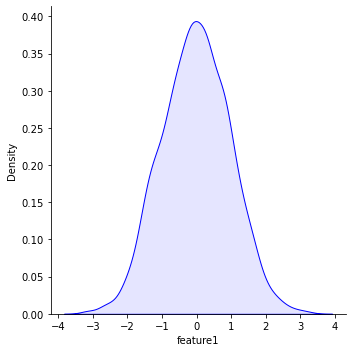

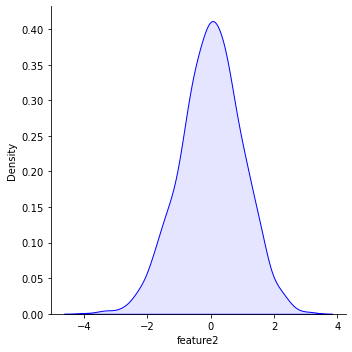

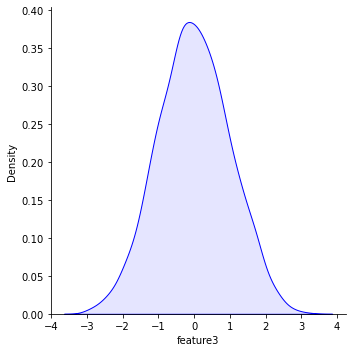

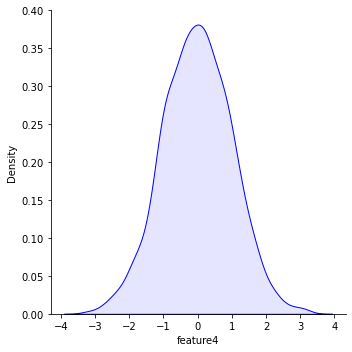

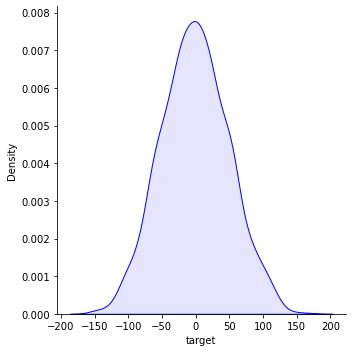

In [137]:
for column in train_set.columns:
    sns.displot(train_set,x=str(column),kind="kde",color="blue",fill="blue",alpha=0.1)
    plt.show()

Todas las variables siguen una distribución normal.

Estudio del número de outliers.

In [100]:
import numpy as np

In [115]:
def detect_outliers(column):
    quantil_1 = np.quantile(train_set[column],0.25)
    quantil_3 = np.quantile(train_set[column],0.75)
    RI = quantil_3 - quantil_1
    outliers=[]
    for row in train_set[column]:
        if row < quantil_1 -1.5*RI or row > quantil_3 + 1.5*RI:
            outliers.append(row)
    return len(outliers)
   
    

In [121]:
for i in train_set.columns:
    print("numero de outliers de " +str(i)+ ": " +str(detect_outliers(i)))

numero de outliers de feature1: 11
numero de outliers de feature2: 20
numero de outliers de feature3: 7
numero de outliers de feature4: 14
numero de outliers de target: 7


Visualización de outliers.

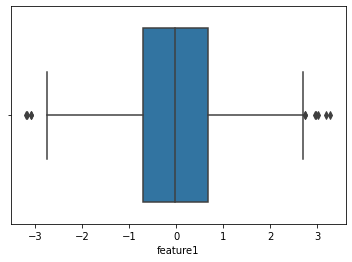

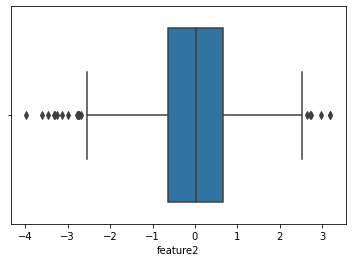

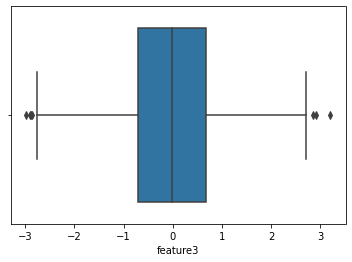

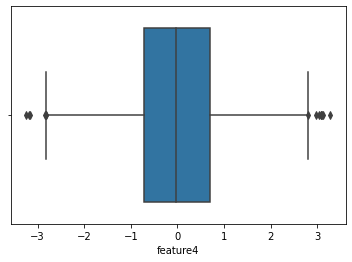

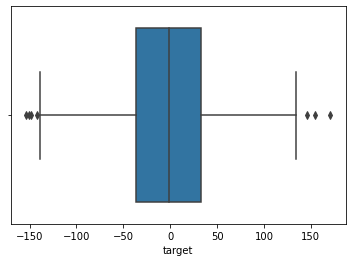

In [136]:
for column in train_set.columns:
    sns.boxplot(x=train_set[str(column)])
    plt.show()

Los outliers no son ni excesivamente altos ni excesivamente bajos, además su ditribución es balanceada, no hace falta eliminarlos. Si se eliminaran, se corre el riesgo de quie en test entren valores atípicos y se predigan incorrectamente.

Estudiemos la correlación entre las variables

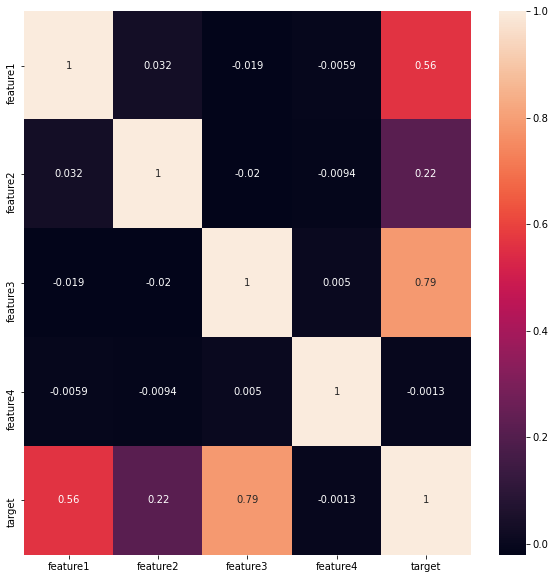

In [144]:
corrMatrix = train_set.corr()
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(corrMatrix,annot=True)
plt.show()

Las correlaciones de feature1, feature2 y feature3 con target son considerables, para construir un modelo predictivo esto es positivo. La correlación entre las variables independientes es practicamente nula, evitamos posibles efectos de colinealidad.

In [156]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

Para evaluar el modelo de regesión lineal, haremos un cross validation de 5 divisiones sobre nuestros datos de entrenamiento, de esta forma nos aseguramos que los resulados sean fiables, mediremos los resultados a traves del error cuadrático medio, como hemos lanzado el modelo varias veces, el error cuadrático medio será la media de las métricas obtenidas cada vez que hemos lanzado el modelo.

In [157]:
X = train_set.drop(["target"],axis="columns")
y = train_set[["target"]]

In [164]:
MSE = []

kFoldNumber = 1
kf = KFold(n_splits=5, random_state=1,shuffle=True)
for train_index, test_index in kf.split(X):
    
    print("Executing k fold = "+str(kFoldNumber))
    kFoldNumber=kFoldNumber+1
    
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    
    model=LinearRegression()
    model.fit(X_train,y_train)
    P_price = model.predict(X_test)
    
    kFoldMeanSquaredError = mean_squared_error(y_test,P_price)
    MSE.append(kFoldMeanSquaredError)
    
MSE_AVG = np.mean(MSE)

print("Mean Squared Error: "+str('{:.50f}'.format(MSE_AVG))) 

Executing k fold = 1
Executing k fold = 2
Executing k fold = 3
Executing k fold = 4
Executing k fold = 5
Mean Squared Error: 0.00000000000000000000000000197681200955817968900784


Sabiendo que la media del target en el set de entrenamiento es de -1.32, el error es prácticamente insignificante.

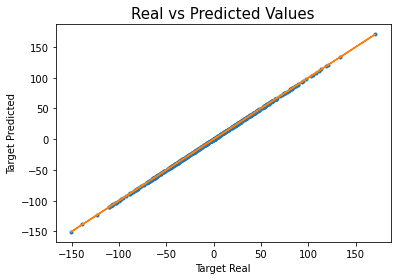

In [173]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=5)
model=LinearRegression()
model.fit(X_train,y_train)
plt.title('Real vs Predicted Values',fontsize=15)
plt.xlabel('Target Real',fontsize=10)
plt.ylabel('Target Predicted',fontsize=10)
_ = plt.plot(y_test, model.predict(X_test), '.', y_test,y_test, '-')

Esta gráfica es otra demostración del la precisión de los resultados.

Ya sabemos que dada la distribución de estos datos un modelo de regresión lineal es muy preciso, lancemos este modelo contra el test_set.

In [171]:
predicciones=model.predict(test_set)

In [185]:
predicciones=pd.DataFrame(predicciones)
predicciones=predicciones.rename(columns={0:"predicciones"})
predicciones.head()

,predicciones
0,49.768770
1,-26.097642
2,11.892201
3,32.167214
4,-35.973501


In [186]:
predicciones.to_csv("predicciones_ejercicio.csv")